#Task - Twitter Emotion Recognition

Dataset - [Tweet Emotion dataset](https://github.com/dair-ai/emotion_dataset)


This package is also available through Hugging Face's NLP package which we are going to use in this notebook.

Run this notebook on GPU for faster training.

## Section 1 - Setup

In this section, we:
1. Import the necessary libraries required in this notebook
2. Load the required dataset

In [1]:
## Downloading NLP package from Hugging Face

!pip install nlp

In [2]:
## importing necessary libraries

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import nlp
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Bidirectional, Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix

In [3]:
## Downloading the tweet emotion recognition data

data = nlp.load_dataset('emotion')
print(data)

Using custom data configuration default


{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000), 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000), 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}


In [4]:
## Loading data by separating labels

train, val, test = data['train'], data['validation'], data['test']

def load_dataset(data):
  """
  This function separates the tweets and labels from the data
  """
  tweets = [each['text'] for each in data]
  labels = [each['label'] for each in data]
  return tweets, labels

tweets_tr, labels_tr = load_dataset(train)
tweets_val, labels_val = load_dataset(val)
tweets_test, labels_test = load_dataset(test)

In [5]:
## Visualize the sample data

for i in range(10):
  print(tweets_tr[i], "------->", labels_tr[i])

i didnt feel humiliated -------> sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake -------> sadness
im grabbing a minute to post i feel greedy wrong -------> anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property -------> love
i am feeling grouchy -------> anger
ive been feeling a little burdened lately wasnt sure why that was -------> sadness
ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny -------> surprise
i feel as confused about life as a teenager or as jaded as a year old man -------> fear
i have been with petronas for years i feel that petronas has performed well and made a huge profit -------> joy
i feel romantic too -------> love


## Section 2 - Preprocessing data

In this section, we:
1. Tokenize the tweets
2. Pad and truncate the sequences

Check out [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) and [pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) from Keras API used in this section.

In [6]:
## Tokenizing the words
## Here we choose 10000 words with maximum frequency fro simplification. Remaining words are marked as unknown, i.e. as <UNK> token.

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')   ## declared globally
tokenizer.fit_on_texts(tweets_tr)

Max len is:  66


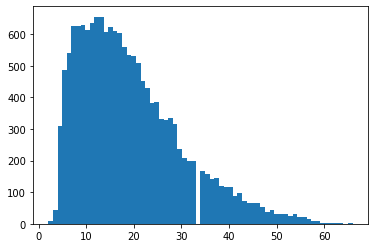

In [7]:
## Visualising training data distribution to perform padding and truncation

tweets_len = [len(tweet.split(' ')) for tweet in tweets_tr]  ## split sentences into words to find the total number
print("Max len is: ", max(tweets_len))
plt.hist(tweets_len, bins=max(tweets_len))
plt.show()

In [8]:
## Pad and truncate the sequences to adjust sentence length. This length should be fixed.
## We choose the maximum length to be 50 here and also we perform padding ans truncation at the end of the senetence using 'post' parameter.

def preprocess_(tweets):
  #tokenize_data(tweets)
  sequences = tokenizer.texts_to_sequences(tweets)
  padded_seq = pad_sequences(sequences, maxlen=50, padding='post', truncating='post') 
  return padded_seq

In [9]:
## Preprocess trainn, val and test data

X_tr = preprocess_(tweets_tr)
X_val = preprocess_(tweets_val)
X_test = preprocess_(tweets_test)

In [10]:
## Check sample data after preprocessing

print("Tweet : ", tweets_tr[0])
print("Processed tweet : ", X_tr[0])  ## 50 dim vector

Tweet :  i didnt feel humiliated
Processed tweet :  [  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## Section 3 - Preparing labels

In this section:
1. Visualize label distribution
2. Convert text labels into numeric labels


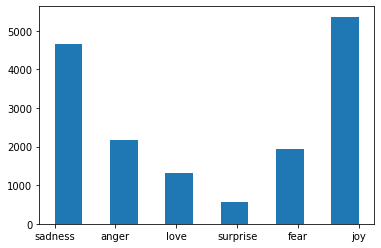

In [11]:
## Visualize the label distribution used for training

classes = list(set(labels_tr))
plt.hist(labels_tr, bins=11)
plt.show()

In [12]:
## Convert all the text labels in data into numeric

classes_to_idx = dict((v,i) for i,v in enumerate(classes))
idx_to_classes = dict((i,v) for i,v in enumerate(classes))

def text_to_num_labels(labels_data):
  return np.array([classes_to_idx[i] for i in labels_data])

In [13]:
## Convert all the train, val and test labels in data into numeric

Y_tr = text_to_num_labels(labels_tr)
Y_val = text_to_num_labels(labels_val)
Y_test = text_to_num_labels(labels_test)

In [14]:
## Check sample data

print("Full dictionary for marking : ", classes_to_idx)
print("Label : ", labels_tr[0])
print("Converted label : ", Y_tr[0]) 

Full dictionary for marking :  {'love': 0, 'anger': 1, 'fear': 2, 'sadness': 3, 'surprise': 4, 'joy': 5}
Label :  sadness
Converted label :  3


## Section 4 - Model creation and training

In this section, we:
1. Create a model for this task
2. Perform training

Refer [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional), [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding), [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM), [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) used in this section

In [15]:
## Define the model

model = Sequential([Embedding(input_dim=10000, output_dim=16, input_length=50),
                    Bidirectional(LSTM(20, return_sequences=True)),
                    Bidirectional(LSTM(20)),
                    Dense(6, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [16]:
## Compile the model

loss = 'sparse_categorical_crossentropy'
optimizer = 'Adam'
metrics = ['accuracy']
num_epochs = 20

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [17]:
## Perform training

history = model.fit(
    X_tr, Y_tr,
    validation_data = (X_val, Y_val),
    epochs = num_epochs,
    callbacks = [EarlyStopping(monitor='val_accuracy', patience=3)])

Epoch 1/20
500/500 [==============================] - 27s 44ms/step - loss: 1.3292 - accuracy: 0.4577 - val_loss: 0.9316 - val_accuracy: 0.6600
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.5638 - accuracy: 0.8029 - val_loss: 0.5440 - val_accuracy: 0.8160
Epoch 3/20
500/500 [==============================] - 21s 42ms/step - loss: 0.3253 - accuracy: 0.8896 - val_loss: 0.4890 - val_accuracy: 0.8445
Epoch 4/20
500/500 [==============================] - 21s 42ms/step - loss: 0.2396 - accuracy: 0.9218 - val_loss: 0.4711 - val_accuracy: 0.8590
Epoch 5/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1795 - accuracy: 0.9439 - val_loss: 0.4707 - val_accuracy: 0.8475
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1448 - accuracy: 0.9558 - val_loss: 0.4457 - val_accuracy: 0.8590
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1194 - accuracy: 0.9634 - val_loss: 0.4091 - val_accuracy:


## Section 5 - Performance Evaluation

In this section, we:
1. Visualize training
2. Check predictions


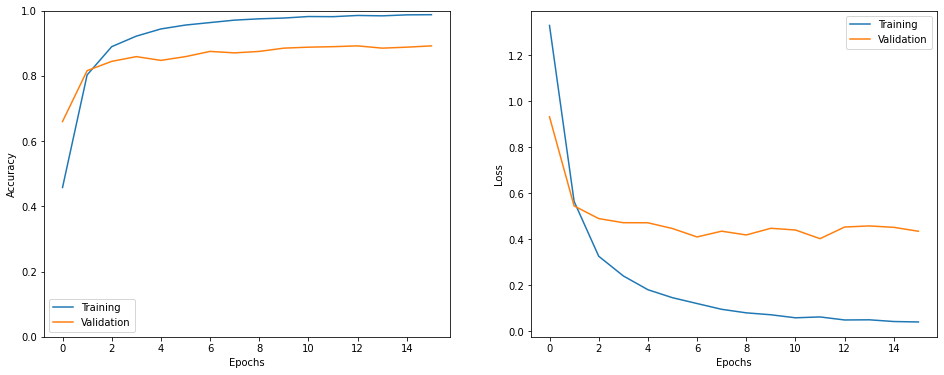

In [18]:
## Visualize training

def show_history(h):
    epochs_trained = len(h.history['loss'])
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

show_history(history)

In [19]:
## Evaluate on test data

model.evaluate(X_test, Y_test)

63/63 [==============================] - 1s 12ms/step - loss: 0.4573 - accuracy: 0.8855


[0.45730841159820557, 0.8855000138282776]

In [46]:
## Check predictions for a random sentence

random_num = random.randint(0, len(classes)-1)
print("Actual sentence is:", tweets_test[random_num])
print("Actual label is:", labels_test[random_num])

tweet_padded = X_test[random_num]
pred = model.predict(np.expand_dims(tweet_padded, axis=0))[0]
out_label = idx_to_classes[np.argmax(pred).astype('uint8')]
print("Predicted emotion is:", out_label)

Actual sentence is: i never make her separate from me because i don t ever want her to feel like i m ashamed with her
Actual label is: sadness
Predicted emotion is: sadness


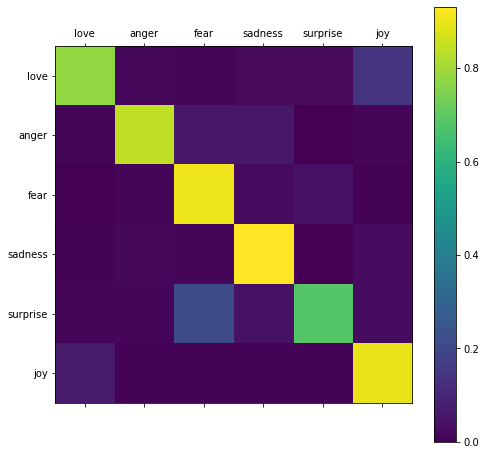

In [47]:
## Visualize confusion matrix

def show_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

preds = np.argmax(model.predict(X_test), axis=-1)
show_confusion_matrix(Y_test, preds, list(classes))